In [1]:
import sys
import glob
import itertools
import numpy as np
import scipy.io as sio
import multiprocessing as mp
import matplotlib.pyplot as plt
from scipy.linalg import eigh, sqrtm
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from sklearn.neighbors import NearestNeighbors

# Clustering algorithms

In [107]:
def construct_affinity(data, sigma, k):
    knn = NearestNeighbors()
    d_sum = np.linalg.norm(data, axis=0).reshape(1, -1)
    data = data / d_sum
    knn.fit(data.T)
    
    N = data.shape[1]
    W = np.zeros((N, N))
    
    for i in range(N):
        dist, ind = knn.kneighbors([data[:, i].T], n_neighbors=k+1)
        dist = dist[0, 1:]
        ind = ind[0, 1:]
        
        for j, d in zip(ind, dist):
            W[i, j] = np.exp(-(d**2)/2.0/(sigma**2))
    
    return W + W.T

In [109]:
def spectral_clustering(affinity, n, normalized=False):
    N = affinity.shape[1]
    d = np.diag(affinity.dot(np.ones((N, 1))).reshape(-1))
    
    laplacian = d - affinity
    
    if np.sum(affinity) == 0:
        return None
    
    if normalized:
        if np.any(np.linalg.eigvals(d) <= 0):
            return None
        
        eigv, vect = eigh(laplacian, d)
    else:
        eigv, vect = eigh(laplacian)
        
    vect = vect[:, :n]
    
    for i in range(n):
        vect[:, i] = vect[:, i]/np.linalg.norm(vect[:, i], axis=0)
        
    Y = vect.T
    
    kmeans = KMeans(n_clusters=n).fit(Y.T)
    z = kmeans.labels_
    
    return z

In [4]:
def compute_dist(x_j, (U_l, mu_l)):
    d = U_l.shape[0]
    left = np.identity(d) - U_l.dot(U_l.T)
    right = x_j.reshape(-1, 1) - mu_l.reshape(-1, 1)

    return np.linalg.norm(left.dot(right))**2

def segmentation_step(U, mu, data, n):
    D, N = data.shape
    d = U[0].shape[0]
    U_n = np.array([U_l.dot(U_l.T) for U_l in U])
    left = np.identity(d) - U_n
    X = np.zeros((n, D, N))
    X[:, :, :] = data - np.array(mu).reshape((n, D, 1))
    dist_n = np.einsum('ijk,ikn->ijn', left, X)
    dist_n = np.linalg.norm(dist_n, axis=1)

    W_n = np.zeros_like(dist_n)
    W_n[dist_n.argmin(0), np.arange(dist_n.shape[1])] = 1

    return W_n

def estimation_step(W, data, n, d):
    mu = []
    U = []
    Y = []

    for i in range(n):
        w_i = W[i, :]
        ind_w_i = np.where(w_i == 1)[0]

        mu_tmp = np.sum(data[:, ind_w_i], 1) / float(ind_w_i.size)
        mu.append(mu_tmp.reshape(-1, 1))

        x_norm = data - mu[i]
        x_norm_w = x_norm[:, ind_w_i]

        mat = x_norm_w.dot(x_norm_w.T)   
        _, vect = np.linalg.eigh(mat)
        # top d eigenvectors
        U.append(vect[:, -d[i]:])

        y_tmp = U[i].T.dot(x_norm_w)
        Y.append(y_tmp)

    return mu, U, Y

def obj_function(W, mu, U, data, n):
    N = data.shape[1]
    obj = 0

    for i in range(n):
        for j in range(N):
            if W[i, j] != 0:
                obj += compute_dist(data[:, j], (U[i], mu[i]))

    return obj

def do_one_rep(data, D, N, n, d, pool=False, rand=None, n_iter=100, debug=False):
    # Initialize mu with random points from the data
    if rand is None:
        ind = np.random.choice(range(N), n, replace=False)
    else:
        ind = rand
        
    mu = [data[:, i] for i in ind]

    # Initialize U with random orthogonal matrix
    I = np.identity(D)
    U = [I[:, :d[i]] for i in range(n)]

    W = np.zeros((n, N))
    cond = True

    i = 0

    while cond:
        W_prec = W
        W = segmentation_step(U, mu, data, n)
        mu, U, y = estimation_step(W, data, n, d)
        cond = (True in (np.sum(np.abs(W - W_prec), 1) > 0)) and (i < n_iter)

        i += 1
        
        if debug:
            print '#iter: %d' % i

    if pool:
        return np.array([y, mu, U, W, obj_function(W, mu, U, data, n)])
    else:
        return y, mu, U, W, obj_function(W, mu, U, data, n)

In [5]:
def ksubspaces(data, n, d, replicates, pool=False, debug=False):
    D, N = data.shape
    y_tot = []
    U_tot = []
    mu_tot = []
    W_tot = []
    obj_tot = []
    
    if pool:
        p = mp.Pool(processes=mp.cpu_count())
        p_list = [p.apply_async(do_one_rep, (data, D, N, n, d, True,))
                  for _ in range(replicates)]
        p_list = [i.get() for i in p_list]
        p.close()
        p.join()
        
        res = np.array(p_list).reshape(replicates, -1)
        amin = np.argmin(res[:, -1])
        
        return res[amin, 1], res[amin, 2], res[amin, 3], res[amin, 0]
    
    for r in range(replicates):
        y, mu, U, W, obj = do_one_rep(data, D, N, n, d, debug=debug)

        y_tot.append(y)
        mu_tot.append(mu)
        U_tot.append(U)
        W_tot.append(W)
        obj_tot.append(obj)
        
        if debug:
            print "Replicate %d done" % r
        
    sys.stdout.write('')
    obj_amin = np.argmin(np.array(obj_tot))
    
    return mu_tot[obj_amin], U_tot[obj_amin], W_tot[obj_amin], y_tot[obj_amin]

In [141]:
def ssc(data, n, tau, mu2, eps=2e-4, n_iter=1500):
    def shrinkage(X, tau):
        X = np.where((X<=tau)&(-tau<=X), 0, X)
        X = np.where(X>tau, X-tau, X)
        X = np.where(X<-tau, X+tau, X)
        
        return X
        
    D, N = data.shape
    C = np.zeros((N, N))
    Lambda = np.zeros((N, N))
    X_tild = data.T.dot(data)
    Z1 = np.linalg.inv(tau*X_tild + mu2*np.identity(N))
    Z = np.ones((N, N))
    undef = lambda x: np.isnan(x).any() or np.isinf(x).any()
    
    i = 0
    
    while np.max(np.abs(Z - C)) > eps and i < n_iter:
        Z2 = tau*X_tild + mu2*(C - Lambda/mu2)
        Z = Z1.dot(Z2)
        C = shrinkage(Z + Lambda/mu2, 1.0/mu2)
        C = C - np.diag(np.diag(C))
        
        Lambda = Lambda + mu2*(Z-C)
        
        if undef(Z) or undef(Lambda) or undef(C):
            return None
        
        i += 1
        
    print '#iter: %d' % i
        
    if np.sum(np.abs(C)) == 0:
        return None
    
    C = np.abs(C)
    C = C / (np.linalg.norm(C, np.inf, axis=0) + 1e-4)
    W = C + C.T
    
    return spectral_clustering(W, n, normalized=True)

In [7]:
def clustering_error(label, groups):
    def hungarian_method(label, groups, n):
        C = np.zeros((n, n))
        
        for i in range(n):
            la = label == i
            n_la = np.sum(la)
            
            for j in range(n):
                gr = groups == j
                n_gr = np.sum(gr)
                inter = np.sum(la & gr)
                
                C[i, j] = n_la + n_gr - 2*inter
        
        _, res = linear_sum_assignment(C)
        return res
    
    n = np.max(label)
    ind = hungarian_method(label-1, groups, n).reshape((-1,))
    gr = np.zeros_like(groups)
    
    for i in range(n):
        gr[groups == i] = ind[i]
        
    err = np.sum((label-1) != gr)
    
    return float(err)/label.size

In [8]:
def clustering_error(labels, groups):
    lbl = labels
    m = max(np.max(lbl), np.max(groups)) + 1
    w = np.bincount(lbl * m + groups, minlength=m*m)
    w = w.reshape((m, m))
    r, c = linear_sum_assignment(np.max(w) - w) # Kuhn-Munkres
    return np.mean(c[lbl] != groups)

# Face clustering

## Grid-search [1-2]

In [84]:
# 128 subjects; 48*42=2016 dimension

mat = sio.loadmat('ExtendedYaleB.mat')
labels = mat['EYALEB_LABEL'].reshape(-1)
data_tmp = mat['EYALEB_DATA']
data = np.c_[data_tmp[:, labels == 1], data_tmp[:, labels == 2]]
labels = np.append(labels[labels == 1], labels[labels == 2])
n = 2

data = data.astype(float)

### Spectral clustering

In [37]:
l_sig = [.1*i for i in range(1, 20)]
l_k = range(2, 12)
l_err = []
err_min = 1.01
opt = None, None

for k, sig in itertools.product(l_k, l_sig):
    W = construct_affinity(data, sigma=sig, k=k)
    groups = spectral_clustering(W, n)
    
    if groups is None:
        continue
    
    err = clustering_error(labels, groups)
    l_err.append(err)
    
    if err < err_min:
        opt = k, sig
        err_min = err
    
print 'Optimal solution for SC: k=%d, sigma=%.2e, err=%.2f' % (opt[0], opt[1], err_min)

Optimal solution for SC: k=2, sigma=4.00e-01, err=0.01


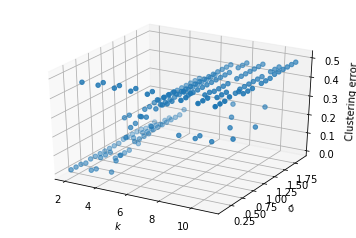

In [47]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
prm = [item for item in itertools.product(l_k, l_sig)]
k_l = [i[0] for i in prm]
s_l = [i[1] for i in prm]
ax = fig.gca(projection='3d')
ax.scatter(k_l, s_l, l_err)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\sigma$')
ax.set_zlabel('Clustering error')
plt.show()

In [34]:
W = construct_affinity(data, sigma=opt[1], k=opt[0])
groups = spectral_clustering(W, n)
print 'Prediction:'
print groups

0.0078125
Prediction:
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### K-subspaces

In [23]:
d = [3, 3]
mu_k, U_k, w, y_k = ksubspaces(data, n, d, 5)
groups = np.argmax(w, 0)

err = clustering_error(labels, groups)
print 'Error rate for K-subspaces: %.2f' % err

Replicates 0 done
Replicates 1 done
Replicates 2 done
Replicates 3 done
Replicates 4 done
Error rate for K-subspaces: 0.06


In [22]:
print 'Predictions:'
print groups

Predictions:
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### SSC

In [30]:
err_min = 1.01
opt = None, None, None

l_tau = data.T.dot(data)
l_tau = np.abs(l_tau - np.diag(np.diag(l_tau)))
l_tau = np.min(np.max(l_tau, axis=1))
tau_min = l_tau

l_mu = np.array([25*i for i in range(1, 80)])
l_tau = l_mu / l_tau

l_tau = [2.8e-5]
l_mu = [3000]

for tau, mu in zip(l_tau, l_mu):
    groups = ssc(data, n, tau, mu, eps=2e-4)
    
    if groups is None:
        continue
    
    err = clustering_error(labels, groups)
    
    if err_min > err:
        opt = tau, mu, groups
        err_min = err
    
print 'Optimal solution for SSC: tau=%.2e, mu=%.2e, err=%.2f' % (opt[0], opt[1], err_min)

Optimal solution for SSC: tau=2.80e-05, mu=3.00e+03, err=0.02


In [18]:
print 'Predictions:'
print opt[2]

Predictions:
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Hyperparameters found

In [49]:
p_sc = (2, 4e-1)
p_ks = ([3, 3], 5)
p_ssc = (3000, 2.8e-5)

## Other individuals (couple)

### Spectral clustering

In [23]:
k_opt, sigma_opt = p_sc
l_err = np.array([])

for j in [2, 10, 20, 30, 38]:
    labels = mat['EYALEB_LABEL'].reshape(-1)
    data = np.c_[data_tmp[:, labels == 1], data_tmp[:, labels == j]]
    labels = np.append(labels[labels == 1], labels[labels == j])
    labels[labels == j] = 2
    n = 2
    
    data = data.astype(float)
    W = construct_affinity(data, sigma=sigma_opt, k=k_opt)
    groups = spectral_clustering(W, n)
    err = clustering_error(labels, groups)
    l_err = np.append(l_err, err)
    print 'Error rate for SC [1-%d]: %.2f' % (j, err)

print '-- Error: %.2f +/- %.2f' % (np.mean(l_err), 2*np.std(l_err))

Error rate for SC [1-2]: 0.01
Error rate for SC [1-10]: 0.49
Error rate for SC [1-20]: 0.02
Error rate for SC [1-30]: 0.48
Error rate for SC [1-38]: 0.03
-- Error: 0.21 +/- 0.45


### K-subspaces

In [116]:
d_opt, r_opt = p_ks
l_err = np.array([])

for j in [2, 10, 20, 30, 38]:
    labels = mat['EYALEB_LABEL'].reshape(-1)
    data = np.c_[data_tmp[:, labels == 1], data_tmp[:, labels == j]]
    labels = np.append(labels[labels == 1], labels[labels == j])
    labels[labels == j] = 2
    n = 2

    data = data.astype(float)
    _, _, w, _ = ksubspaces(data, n, d_opt, r_opt)
    groups = np.argmax(w, 0)
    err = clustering_error(labels, groups)
    l_err = np.append(l_err, err)
    print 'Error rate for K-subspaces [1-%d]: %.2f' % (j, err)

print '-- Error: %.2f +/- %.2f' % (np.mean(l_err), 2*np.std(l_err))

Error rate for K-subspaces [1-2]: 0.07
Error rate for K-subspaces [1-10]: 0.30
Error rate for K-subspaces [1-20]: 0.15
Error rate for K-subspaces [1-30]: 0.25
Error rate for K-subspaces [1-38]: 0.12
-- Error: 0.18 +/- 0.17


### SSC

In [36]:
mu2_opt, tau_opt = p_ssc
tau_n = tau_opt is None

l_err = np.array([])

for j in [2, 10, 20, 30, 38]:
    labels = mat['EYALEB_LABEL'].reshape(-1)
    data = np.c_[data_tmp[:, labels == 1], data_tmp[:, labels == j]]
    labels = np.append(labels[labels == 1], labels[labels == j])
    labels[labels == j] = 2
    n = 2

    data = data.astype(float)
    
    if tau_n:
        tau_opt = data.T.dot(data)
        tau_opt = np.abs(tau_opt - np.diag(np.diag(tau_opt)))
        tau_opt = np.min(np.max(tau_opt, axis=1))
        tau_opt = mu2_opt * 1.0 / tau_opt
        
    groups = ssc(data, n, tau_opt, mu2_opt, eps=2e-4)
    err = clustering_error(labels, groups)
    l_err = np.append(l_err, err)
    print 'Error rate for SSC [1-%d]: %.2f' % (j, err)
    
print '-- Error: %.2f +/- %.2f' % (np.mean(l_err), 2*np.std(l_err))

Error rate for SSC [1-2]: 0.02
Error rate for SSC [1-10]: 0.28
Error rate for SSC [1-20]: 0.17
Error rate for SSC [1-30]: 0.23
Error rate for SSC [1-38]: 0.11
-- Error: 0.16 +/- 0.18


## Clustering error as a function of the number of groups

### On a number of individuals

In [48]:
labels_tmp = mat['EYALEB_LABEL'].reshape(-1)

k_opt, sigma_opt = p_sc
mu2_opt, tau_opt = p_ssc
tau_n = tau_opt is None
# TODO: change value for d_opt
d_opt, r_opt = p_ks

data = data_tmp[:, labels_tmp == 1]
labels = labels_tmp[labels_tmp == 1]

for l in range(2, 11):
    data = np.c_[data, data_tmp[:, labels_tmp == l]]
    data = data.astype(float)
    labels = np.append(labels, labels_tmp[labels_tmp == l])
    
## K-subspaces
## TODO: change value for d_opt
#d_opt = [3] * l
#_, _, w, _ = ksubspaces(data, l, d_opt, r_opt, debug=True)
#groups = np.argmax(w, 0)
#err = clustering_error(labels, groups)
#print 'K-subspaces error: %.2f' % err
    
# Spectral clustering
W = construct_affinity(data, sigma=sigma_opt, k=k_opt)
groups = spectral_clustering(W, l)
err = clustering_error(labels, groups)
print 'Spectral clustering error: %.2f' % err

# SSC
if tau_n:
    tau_opt = data.T.dot(data)
    tau_opt = np.abs(tau_opt - np.diag(np.diag(tau_opt)))
    tau_opt = np.min(np.max(tau_opt, axis=1))
    tau_opt = mu2_opt * 1.0 / tau_opt

groups = ssc(data, l, tau_opt, mu2_opt, eps=2e-4)
err = clustering_error(labels, groups)
print 'SSC error: %.2f' % err

Spectral clustering error: 0.49
SSC error: 0.53


### Spectral clustering & SSC

In [111]:
labels_tmp = mat['EYALEB_LABEL'].reshape(-1)
# TODO: change value
n_labels = 38

k_opt, sigma_opt = p_sc
mu2_opt, tau_opt = p_ssc
tau_n = tau_opt is None

n_algo = ['Spectral clustering', 'SSC']
l_err = [np.array([])] * len(n_algo)
data = data_tmp[:, labels_tmp == 1]
labels = labels_tmp[labels_tmp == 1]

l_ind = [2, 5, 10, 15, 20, 30]

for l in range(2, n_labels+1):
    data = np.c_[data, data_tmp[:, labels_tmp == l]]
    data = data.astype(float)
    labels = np.append(labels, labels_tmp[labels_tmp == l])
    
    if l not in l_ind:
        continue
    
    # Spectral clustering
    W = construct_affinity(data, sigma_opt, k_opt)
    groups = spectral_clustering(W, l)
    err = clustering_error(labels, groups)
    l_err[0] = np.append(l_err[0], err)
    
    # SSC
    if tau_n:
        tau_opt = data.T.dot(data)
        tau_opt = np.abs(tau_opt - np.diag(np.diag(tau_opt)))
        tau_opt = np.min(np.max(tau_opt, axis=1))
        tau_opt = mu2_opt * 1.0 / tau_opt
        
    groups = ssc(data, l, tau_opt, mu2_opt, eps=2e-4, n_iter=300)
    err = clustering_error(labels, groups)
    l_err[-1] = np.append(l_err[-1], err)
    
    print 'Individuals 1-%d done' % l

Individuals 1-2 done
Individuals 1-5 done
Individuals 1-10 done
Individuals 1-15 done
Individuals 1-20 done
Individuals 1-30 done


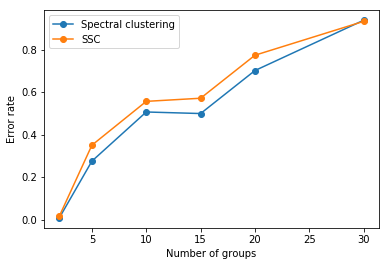

In [112]:
plt.figure()

for err, al in zip(l_err, n_algo):
    #plt.plot(range(2, n_labels+1), err, 'o-', label=al)
    plt.plot(l_ind, err, 'o-', label=al)
    
plt.xlabel('Number of groups')
plt.ylabel('Error rate')
plt.legend()
plt.show()

### Only K-subspaces

In [ ]:
labels_tmp = mat['EYALEB_LABEL'].reshape(-1)
# TODO: change value
n_labels = 20

# TODO: change value for d_opt
d_opt, r_opt = p_ks

n_algo = ['K-subspaces']
l_err = [np.array([])] * len(n_algo)
data = data_tmp[:, labels_tmp == 1]
labels = labels_tmp[labels_tmp == 1]

for l in range(2, n_labels+1):
    data = np.c_[data, data_tmp[:, labels_tmp == l]]
    data = data.astype(float)
    labels = np.append(labels, labels_tmp[labels_tmp == l])
    
    # K-subspaces
    # TODO: change value for d_opt
    d_opt = [3] * l
    _, _, w, _ = ksubspaces(data, l, d_opt, r_opt)
    groups = np.argmax(w, 0)
    err = clustering_error(labels, groups)
    l_err[0] = np.append(l_err[0], err)

### All

In [ ]:
labels_tmp = mat['EYALEB_LABEL'].reshape(-1)
# TODO: change value
n_labels = 38

k_opt, sigma_opt = p_sc
# TODO: change value for d_opt
d_opt, r_opt = p_ks
mu2_opt, tau_opt = p_ssc
tau_n = tau_opt is None

n_algo = ['Spectral clustering', 'K-subspaces', 'SSC']
l_err = [np.array([])] * len(n_algo)
data = data_tmp[:, labels_tmp == 1]
labels = labels_tmp[labels_tmp == 1]

for l in range(2, n_labels+1):
    data = np.c_[data, data_tmp[:, labels_tmp == l]]
    data = data.astype(float)
    labels = np.append(labels, labels_tmp[labels_tmp == l])
    
    # Spectral clustering
    W = construct_affinity(data, sigma=sigma_opt, k=k_opt)
    groups = spectral_clustering(W, l)
    err = clustering_error(labels, groups)
    l_err[0] = np.append(l_err[0], err)
    
    # K-subspaces
    # TODO: change value for d_opt
    d_opt = [3] * l
    _, _, w, _ = ksubspaces(data, l, d_opt, r_opt)
    groups = np.argmax(w, 0)
    err = clustering_error(labels, groups)
    l_err[1] = np.append(l_err[1], err)
    
    # SSC
    if tau_n:
        tau_opt = data.T.dot(data)
        tau_opt = np.abs(tau_opt - np.diag(np.diag(tau_opt)))
        tau_opt = np.min(np.max(tau_opt, axis=1))
        tau_opt = mu2_opt * 1.0 / tau_opt
        
    groups = ssc(data, l, tau_opt, mu2_opt, eps=2e-4)
    err = clustering_error(labels, groups)
    l_err[2] = np.append(l_err[2], err)

# Motion segmentation

In [123]:
def load_vid():
    names = glob.glob('Hopkins155/*/*_truth.mat')
    res = []
    
    for name in names:
        data = sio.loadmat(name)
        x = data['x']
        lab = data['s']
        n = np.max(lab)
        N, F = x.shape[1:]
        D = 2*F
        x = np.transpose(x[:2, :, :], (0, 2, 1))
        x = x.reshape(D, N, order='F')
        res.append([x, lab])
        
    return res

In [145]:
l_data = load_vid()
l_err_sc = []
l_err_ssc = []

for data in l_data:
    X, y = data
    y = y.ravel()
    n_groups = np.max(y)
    
    # SC
    W = construct_affinity(X, sigma=1, k=8)
    W_2 = construct_affinity_v2(X, sigma=1, k=8)
    groups = spectral_clustering(W, n_groups)
    err = clustering_error(y, groups)
    l_err_sc.append(err)
    
    # SSC
    #tau_min = X.T.dot(X)
    #tau_min = np.abs(tau_min - np.diag(np.diag(tau_min)))
    #tau_min = np.min(np.max(tau_min, axis=1))
    #
    #tau_opt = 10*tau_min
    #mu_opt = 1.0/5/tau_opt
    #
    #groups = ssc(X, n_groups, tau_opt, mu_opt, eps=2e-4, n_iter=300)
    #err = clustering_error(y, groups)
    #l_err_ssc.append(err)

print 'SC error: %.2f +/- %.2f; %.2f' % (np.mean(l_err_sc), 2*np.std(l_err_sc), np.median(l_err_sc))
print 'SSC error: %.2f +/- %.2f; %.2f' % (np.mean(l_err_ssc), 2*np.std(l_err_ssc), np.median(l_err_ssc))

SC error: 0.21 +/- 0.35; 0.22
SSC error: nan +/- nan; nan
